# 필요한 패키지 import
- `imutils`: OpenCV에서 사용하기 쉬운 간단한 기능을 구현한 파이썬 패키지입니다. 이미지 뷰, 회전, 이동, 색상공간 변경 등의 편리한 기능을 제공

- `wget`: 파이썬으로 웹에서 파일을 다운로드 받기 위한 도구

- `tensorflow.keras.preprocessing.image`: Keras에서 제공하는 이미지 전처리 도구입니다. 이미지를 넘파이 배열로 로딩하거나 데이터 확장(data augmentation)을 적용하는 등의 작업을 할 수 있음.

- `tensorflow.keras.applications`: 사전에 훈련된 모델(예: MobileNetV2, Xception 등)을 로드하기 위한 도구입니다.

- `tensorflow.keras.layers`: 신경망의 계층을 구현하는 데 사용되는 도구

- `tensorflow.keras.models`: Keras 모델을 구성하고 컴파일하는 데 사용되는 도구

- `tensorflow.keras.optimizers`: 최적화 알고리즘(예: Adam, SGD 등)을 제공하는 도구

- `sklearn.preprocessing` 데이터 전처리 도구를 제공합. 예를 들어, LabelBinarizer는 범주형 레이블을 이진 형태로 변환하는 데 사용한다.

- `sklearn.model_selection`: 데이터를 학습 세트와 테스트 세트로 분할하는 데 사용되는 도구

- `sklearn.metrics`: 분류 리포트와 같은 성능 메트릭을 계산하는 도구

- `matplotlib.pyplot`: 데이터를 시각화하는 데 사용되는 도구

- `numpy`: 수학적 연산을 위한 라이브러리

- `os`: 운영체제와 상호작용하는 기능을 제공

- `cv2`: OpenCV라고도 하는 이미지 처리 라이브러리

- `tensorflow`: 기계 학습과 딥러닝 모델을 만들기 위한 오픈 소스 라이브러리

-`tensorflow_datasets.public_api`: 텐서플로우 데이터셋 API로, 다양한 데이터셋에 대한 접근을 제공

In [ ]:
# import the necessary packages
!pip install imutils
!pip install wget
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.applications import Xception
from tensorflow.keras.layers import Dropout,Convolution2D,MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os
import wget
import cv2
import tensorflow as tf
import tensorflow_datasets.public_api as tfds

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9657 sha256=8a0d8181a6380828bc42b1edc0cba4c55ed4a30b85b1254c57cefe1c55b8d3a3
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


## 데이터셋 다운로드
- 사용 데이터 셋 : **[Flicker Logos 27](https://www.kaggle.com/datasets/sushovansaha9/flickr-logos-27-dataset)**

  훈련 세트에  27개의 로고 클래스(각 클래스당 30개의 이미지)에 해당하는 810개의 주석이 달린 이미지가 포함되어 있음. 현재 시간 상 많은 양의 데이터 셋을 학습시킬 시간이 없어 Flickr Logos 27을 사용하였으나, 이 후에 LogoDet-3K (3,000개의 로고 카테고리, 약 200,000개의 수동 주석이 달린 로고 개체, 158,652개의 이미지가 포함된 전체 주석을 갖춘 가장 큰 로고 감지 데이터 세트)를 이용하여 더욱 정확도 높은 모델을 점진적으로 구현할 예정

In [ ]:
_URL = 'http://image.ntua.gr/iva/datasets/flickr_logos/flickr_logos_27_dataset.tar.gz'
wget.download(_URL)

'flickr_logos_27_dataset.tar.gz'

In [ ]:
!ls # 데이터셋이 설치된 파일 경로 확인

flickr_logos_27_dataset.tar.gz	sample_data


In [ ]:
zip_dir = tf.keras.utils.get_file('./logo', origin=_URL, untar=True,extract=True)

101827904/101827904 [==============================] - 16s 0us/step


In [ ]:
import tarfile

fname = './flickr_logos_27_dataset.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [ ]:
fname = './flickr_logos_27_dataset/flickr_logos_27_dataset_images.tar.gz'

if fname.endswith("tar.gz"):
    tar = tarfile.open(fname, "r:gz")
    tar.extractall()
    tar.close()

In [ ]:
src_dir = "flickr_logos_27_dataset_images"
dest = "LOGOS"

if not os.path.exists(dest):
    os.makedirs(dest)

## Preprocessing (로고 이미지 데이터 전처리)
모델 훈련 전 필요한 데이터 전처리 과정으로, 데이터를 모델이 이해할 수 있는 형식으로 변환하며, 모델의 성능을 개선하기 위해 필요한 단계

In [ ]:
# andas를 사용하여 로컬에서 로고 이미지의 레이블과 경로가 저장된 .txt 파일을 읽어온다.
import pandas as pd

In [ ]:
# 이미지의 경로와 레이블을 각각 X, Y 변수에 저장
X = df.iloc[:,0]
Y = df.iloc[:,1]
dtdir = './flickr_logos_27_dataset_images/'
im = df[0][0]
size = df.iloc[:,3:]

In [ ]:
size

,3,4,5,6
0,38,12,234,142
1,242,208,413,331
2,13,5,89,60
3,43,122,358,354
4,83,63,130,93
...,...,...,...,...
4531,15,6,253,54
4532,136,161,304,222
4533,2,4,499,106
4534,1,69,342,157


In [ ]:
# 이미지의 경로를 가져와 cv2 라이브러리를 사용하여 이미지를 불러오고,
# size 데이터를 이용해 이미지를 일정 크기로 자르는 작업을 수행
img = os.path.join(dtdir,im)
size = size.values.tolist()

In [ ]:
size[0][0],size[0][1],size[0][2],size[0][3]

(38, 12, 234, 142)

(210, 280, 3)

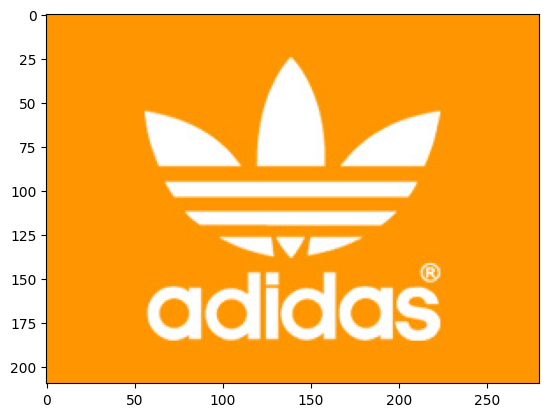

In [ ]:
image = cv2.imread(img)
plt.imshow(image)
image.shape

(130, 196, 3)

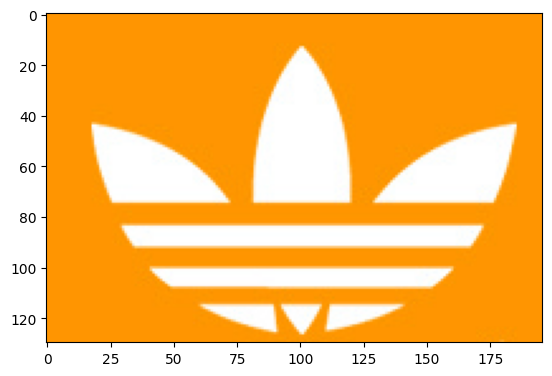

In [ ]:
image = cv2.imread(img)
image = image[size[0][1]:size[0][3],size[0][0]:size[0][2]]
plt.imshow(image)
image.shape

In [ ]:
# 테스트 쿼리를 위한 데이터를 불러오고, 테스트용 디렉토리를 생성
# 각 로고 브랜드에 대한 디렉토리를 생성한다.
# 이 과정은 훈련용 데이터에 대해서도 같이 수행됨
query = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_query_set_annotation.txt", sep='\s+',header=None)

In [ ]:
query

,0,1
0,2403695909.jpg,Adidas
1,2912587920.jpg,Adidas
2,3441398196.jpg,Adidas
3,4605630935.jpg,Adidas
4,4606245138.jpg,Adidas
...,...,...
265,3480640208.jpg,none
266,3486224308.jpg,none
267,3486430785.jpg,none
268,3490185235.jpg,none


(500, 437, 3)

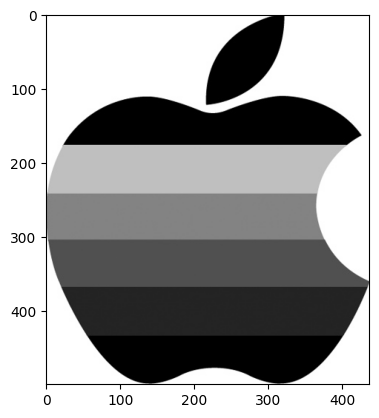

In [ ]:
img = os.path.join(dtdir,query[0][5])
image = cv2.imread(img)
plt.imshow(image)
image.shape

In [ ]:
# 각 로고 브랜드에 해당하는 이미지를 해당 브랜드의 폴더에 저장하며,
# 폴더 내에는 브랜드별로 이미지가 정리된다.
testdist = 'TEST'

In [ ]:
if not os.path.exists(testdist):
    os.makedirs(testdist)

In [ ]:
y = list(set(list(Y)))
y.sort()

In [ ]:
for i in y:
    os.makedirs(os.path.join(testdist,i))
    os.makedirs(os.path.join(dest,i))

In [ ]:
# "distractor"는 분류에 필요하지 않은 데이터, 즉 노이즈 데이터를 의미한다.
distractor = pd.read_csv("./flickr_logos_27_dataset/flickr_logos_27_dataset_distractor_set_urls.txt", sep='\s+',header=None)

In [ ]:
distractor

,0
0,http://farm2.static.flickr.com/1184/1013364004...
1,http://farm2.static.flickr.com/1108/1047095104...
2,http://farm2.static.flickr.com/1359/1076885577...
3,http://farm1.static.flickr.com/53/110432189_6d...
4,http://farm2.static.flickr.com/1144/1153048029...
...,...
4202,http://farm2.static.flickr.com/1254/889763557_...
4203,http://farm2.static.flickr.com/1308/901063602_...
4204,http://farm1.static.flickr.com/18/93551127_fed...
4205,http://farm2.static.flickr.com/1033/978252884_...


In [ ]:
# 마지막으로 이미지의 높이(HEIGHT)와 너비(WIDTH)를 설정
# 이는 모델에 입력할 이미지의 크기를 일관되게 유지하기 위한 작업이다.
HEIGHT = 224
WIDTH =  224

## Removing Corrupt Images
- `Corrupt Images` : 손상되었거나, 읽을 수 없는 이미지
- 이러한 이미지는 학습 과정에서 에러를 발생시킬 수 있으므로 제거하는 것이 중요하다.

In [ ]:
# 모든 학습 이미지에 대하여 Corrupt Images 를 찾아낸다.
for i in range(len(X)):
    try:
        destrain = os.path.join(dest,Y[i])
        savepath = os.path.join(destrain,X[i])
        img  = os.path.join(dtdir,X[i])
        image = cv2.imread(img)
        image = image[size[i][1]:size[i][3],size[i][0]:size[i][2]]
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass


error
error
error
error
error


In [ ]:
A = query.iloc[:,0]
B = query.iloc[:,1]

In [ ]:
A

0      2403695909.jpg
1      2912587920.jpg
2      3441398196.jpg
3      4605630935.jpg
4      4606245138.jpg
            ...      
265    3480640208.jpg
266    3486224308.jpg
267    3486430785.jpg
268    3490185235.jpg
269    3490913574.jpg
Name: 0, Length: 270, dtype: object

In [ ]:
# test image에 대하여 corrupt 이미지를 찾아낸다.
for i in range(len(A)):
    try:
        destrain = os.path.join(testdist,B[i])
        savepath = os.path.join(destrain,A[i])
        img  = os.path.join(dtdir,A[i])
        image = cv2.imread(img)
        image = cv2.resize(image,(WIDTH,HEIGHT))
        cv2.imwrite(savepath,image)
    except:
        print('error')
        pass


In [ ]:
# 이미지의 모든 경로를 가져온다.
imagePaths = list(paths.list_images(testdist))

TEST/Google/2770852623.jpg


(224, 224, 3)

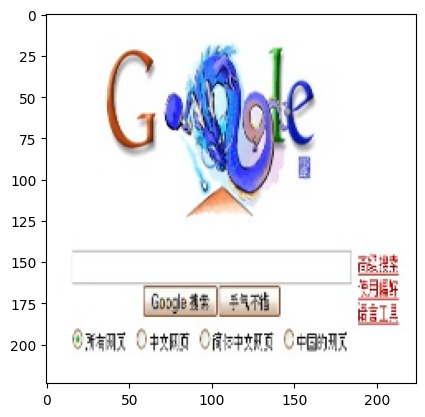

In [ ]:
# 이미지가 잘 불러와지는지 확인한다.
img = imagePaths[40]
print(img)
image = cv2.imread(img)
plt.imshow(image)
image.shape

## Image Augmentation
이미지 증강 및 시각화를 위한 과정이다. 이는 **데이터 증가**, **Overfitting 방지**, **모델 성능 향상**의 목적으로 이루어진다.

이를 위하여 `ImageDataGenerator`를 사용한다.

In [ ]:
train = ImageDataGenerator(
rescale = 1/255,
horizontal_flip=True,
vertical_flip=True,
shear_range=0.2,
zoom_range=0.2,
featurewise_center=True, # Set input mean to 0 over the dataset, feature-wise
featurewise_std_normalization=True, # Divide inputs by std of the dataset, feature-wise
rotation_range=40, # Degree range for random rotations
width_shift_range=0.2,
height_shift_range=0.2,
fill_mode='nearest',
validation_split = 0.2)

In [ ]:
imagePaths = list(paths.list_images(dest))

In [ ]:
os.makedirs('preview')

In [ ]:
img = load_img(imagePaths[50])  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, 150, 150)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in train.flow(x, batch_size=1,
                          save_to_dir='preview', save_prefix='yh', save_format='jpeg'):
    i += 1
    if i > 10:
        break  # otherwise the generator would loop indefinitely

/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


## Samples Visualization

특정 이미지를 불러와서 증강시키는 과정을 시각화

(224, 224, 3)

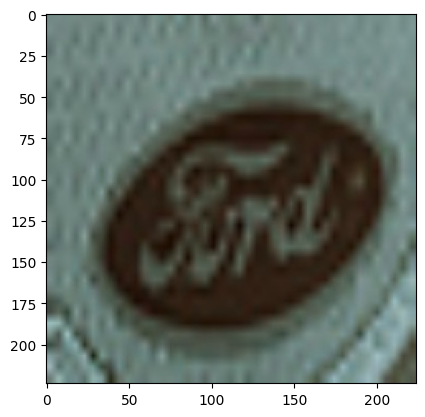

In [ ]:
image = cv2.imread(imagePaths[50])
plt.imshow(image)
image.shape

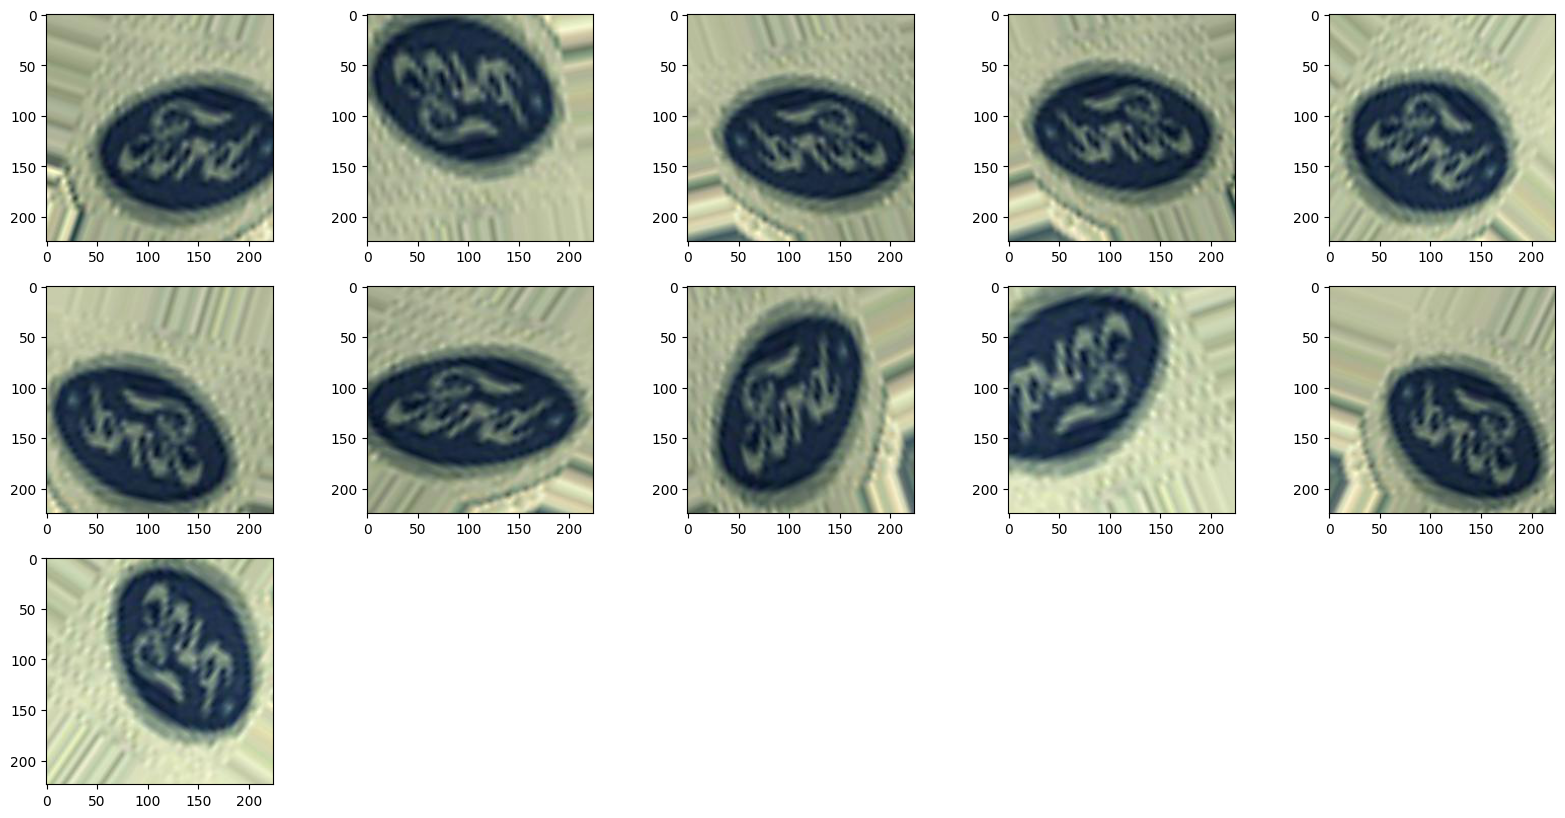

In [ ]:
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

images = []
# 증감된 이미지를 preivew 디렉토리에 저장한다.
for img_path in glob.glob('preview/*.jpeg'):
    images.append(mpimg.imread(img_path))

plt.figure(figsize=(20,10))
columns = 5

# 저장된 이미지를 불러온 후, 시각화 하여 증강이 잘 되었는지 확인
for i, image in enumerate(images):
    plt.subplot(int(len(images) / columns + 1), columns, i + 1)
    plt.imshow(image)

In [ ]:
# 초기 설정 값을 설정 (이 후 학습과정에 사용되는 파라미터들)

# 이미지의 높이와 너비
HEIGHT = 224
WIDTH = 224

INIT_LR = 1e-4 # 초기 학습률
EPOCHS =  100 # epoch 수
BS = 256 # 배치 크기

## Splitting into Train and Validation Set

### 이미지 파일을 로드하고 전처리

In [ ]:
trainset = train.flow_from_directory(dest,
target_size = (WIDTH,HEIGHT),
batch_size = BS,
shuffle=False,
seed=42,
color_mode='rgb',
subset = 'training',
class_mode='categorical')

Found 648 images belonging to 27 classes.


In [ ]:
validset = train.flow_from_directory(dest,
target_size = (WIDTH,HEIGHT),
batch_size = BS,
shuffle=False,
seed=42,
color_mode='rgb',
subset = 'validation',
class_mode='categorical')

Found 161 images belonging to 27 classes.


In [ ]:
imagePaths = list(paths.list_images(dest))

In [ ]:
#trainset.filenames
trainset.class_indices

{'Adidas': 0,
 'Apple': 1,
 'BMW': 2,
 'Citroen': 3,
 'Cocacola': 4,
 'DHL': 5,
 'Fedex': 6,
 'Ferrari': 7,
 'Ford': 8,
 'Google': 9,
 'HP': 10,
 'Heineken': 11,
 'Intel': 12,
 'McDonalds': 13,
 'Mini': 14,
 'Nbc': 15,
 'Nike': 16,
 'Pepsi': 17,
 'Porsche': 18,
 'Puma': 19,
 'RedBull': 20,
 'Sprite': 21,
 'Starbucks': 22,
 'Texaco': 23,
 'Unicef': 24,
 'Vodafone': 25,
 'Yahoo': 26}

## Model Architecture

- 현재 코드에서는 `Xception` 모델을 기반으로 한 Transfer Learning 방법을 사용한다. `Xception`은 ImageNet 데이터셋에서 사전 훈련된 모델으로, 딥러닝에서 공통적으로 사용한다.


In [ ]:
# load the MobileNetV2 network, ensuring the head FC layer sets are
# left off

# inclure_top이 Flase로 설정되어 있어, Xception의 최상위 층은 제외하고,
# 특성 추출 부분만 사용한다.
baseModel = Xception(weights="imagenet", include_top=False,input_tensor=Input(shape=(WIDTH, HEIGHT, 3)))

# construct the head of the model that will be placed on top of the
# the base model

# 기본 모델의 출력 위에 새로운 층을 쌓아올려서 특정 작업에 적합한 헤드(head)를 생성
# 이 헤드는 AveragePooling2D, Flatten, Dense, Dropout, Dense 층으로 구성된다.
headModel = baseModel.output

headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)

headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)

# 마지막 Dense 층의 활성화 함수로는 softmax를 사용하여
# 다중 클래스 분류 문제를 처리할 수 있게 한다.
headModel = Dense(trainset.num_classes, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# 모델을 컴파일하여 학습을 준비
# compile our model
print("[INFO] compiling model...")
#sgd = SGD(lr=INIT_LR,momentum=0.9,nesterov=False)
# 손실 함수로는 다중 클래스 분류에 적합한 'categorical_crossentropy'를 사용하고,
# 최적화기로는 Adam을 사용
# 또한 훈련 과정에서 정확도를 모니터링하기 위해 'accuracy'를 메트릭으로 설정
model.compile(loss="categorical_crossentropy", optimizer='Adam',metrics=["accuracy"])
# train the head of the network

NameError: ignored

In [ ]:
totalTrain = len(list(paths.list_images(dest)))
totalTrain

809

## Train Results

In [ ]:
H = model.fit_generator(
	trainset,
  validation_data = validset,
	epochs=EPOCHS)

<ipython-input-47-3c3e4bbb8f0b>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  H = model.fit_generator(


Epoch 1/100
3/3 [==============================] - 47s 13s/step - loss: 3.7512 - accuracy: 0.0262 - val_loss: 3.1669 - val_accuracy: 0.1553
Epoch 2/100
3/3 [==============================] - 17s 6s/step - loss: 3.2321 - accuracy: 0.1142 - val_loss: 2.9860 - val_accuracy: 0.2360
Epoch 3/100
3/3 [==============================] - 18s 6s/step - loss: 3.0297 - accuracy: 0.1590 - val_loss: 2.8419 - val_accuracy: 0.2857
Epoch 4/100
3/3 [==============================] - 15s 5s/step - loss: 2.8342 - accuracy: 0.2392 - val_loss: 2.6061 - val_accuracy: 0.4596
Epoch 5/100
3/3 [==============================] - 12s 5s/step - loss: 2.6593 - accuracy: 0.3025 - val_loss: 2.4182 - val_accuracy: 0.4348
Epoch 6/100
3/3 [==============================] - 15s 6s/step - loss: 2.4962 - accuracy: 0.3102 - val_loss: 2.2113 - val_accuracy: 0.4969
Epoch 7/100
3/3 [==============================] - 16s 7s/step - loss: 2.3478 - accuracy: 0.3657 - val_loss: 2.0805 - val_accuracy: 0.4720
Epoch 8/100
3/3 [=========

## Result Plot

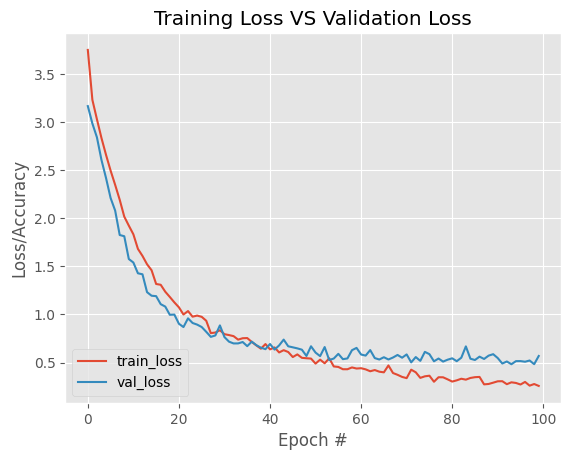

<Figure size 640x480 with 0 Axes>

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.title("Training Loss VS Validation Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.show()
plt.savefig('graph.png')

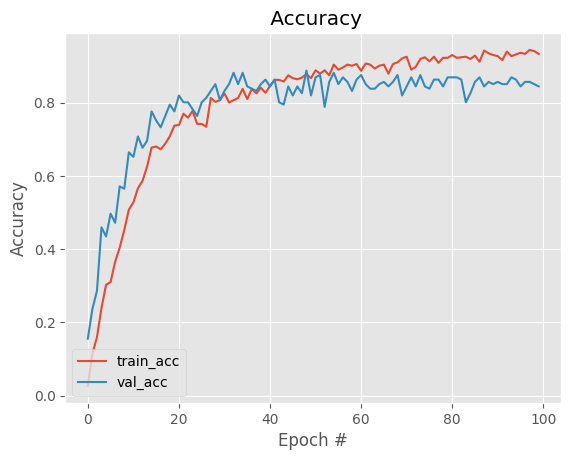

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title(" Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
plt.legend(loc="lower left")
plt.show()

## F1-score Precision Recall

In [ ]:
# reset the testing generator and then use our trained model to
# make predictions on the data
print("[INFO] evaluating after fine-tuning network...")
validset.reset()
predIdxs = model.predict(x=validset)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(validset.classes, predIdxs,
	target_names=validset.class_indices.keys()))
# serialize the model to disk
print("[INFO] serializing network...")
model.save('logo.model', save_format="h5")

[INFO] evaluating after fine-tuning network...


/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1861: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/preprocessing/image.py:1871: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn(


1/1 [==============================] - 3s 3s/step
              precision    recall  f1-score   support

      Adidas       0.67      0.33      0.44         6
       Apple       0.86      1.00      0.92         6
         BMW       1.00      0.83      0.91         6
     Citroen       1.00      0.83      0.91         6
    Cocacola       0.86      1.00      0.92         6
         DHL       0.80      0.67      0.73         6
       Fedex       1.00      1.00      1.00         6
     Ferrari       1.00      1.00      1.00         6
        Ford       0.62      0.83      0.71         6
      Google       1.00      1.00      1.00         6
          HP       1.00      1.00      1.00         6
    Heineken       1.00      0.50      0.67         6
       Intel       0.86      1.00      0.92         6
   McDonalds       1.00      0.67      0.80         6
        Mini       0.86      1.00      0.92         6
         Nbc       1.00      1.00      1.00         6
        Nike       0.71      0.

## Some Prdicition from Test Set

In [ ]:
testimage = list(paths.list_images('./flickr_logos_27_dataset_images'))

In [ ]:
model.get_config

<bound method Functional.get_config of <keras.engine.functional.Functional object at 0x7f379c20e7a0>>

In [ ]:
from PIL import Image
def predimage(path):
    image = Image.open(path)
    plt.imshow(image)
    test = load_img(path,target_size=(WIDTH,HEIGHT))
    test = img_to_array(test)
    test = np.expand_dims(test,axis=0)
    test /= 255
    result = model.predict(test,batch_size = BS)
    y_class = result.argmax(axis=-1)
    result = (result*100)
    result = list(np.around(np.array(result),1))
    print(result)
    print(y[y_class[0]])

1/1 [==============================] - 1s 1s/step
[array([ 2.2,  1. ,  1.1,  0.4,  0.9,  8.6,  9.5,  0.5,  0.7,  1.1,  0.5,
        8.3,  1.5, 16.3,  4.8,  0.1,  1.3,  1.2,  1.6,  0.8, 18.3,  0.6,
        2.7,  2. ,  5.9,  8. ,  0.2], dtype=float32)]
RedBull


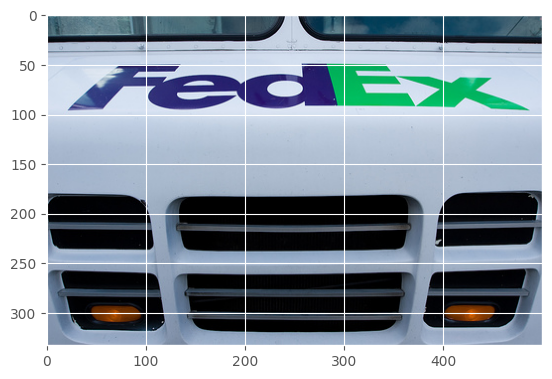

In [ ]:
predimage(testimage[56])

1/1 [==============================] - 0s 30ms/step
[array([ 0.8,  1. ,  0.6,  1.4, 13.6,  1.9,  1. ,  0.4,  2.5,  4.7,  0.2,
        0.6,  1. ,  3.5,  0.5,  6.9,  1.1, 24.8,  0.1,  0.5,  2. ,  1.3,
        0.5,  1.5,  7.4, 19.1,  1.3], dtype=float32)]
Pepsi


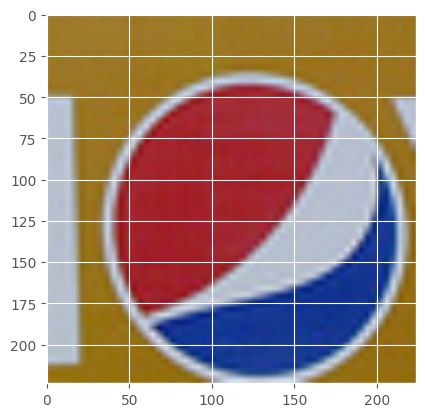

In [ ]:
predimage(imagePaths[2])

1/1 [==============================] - 0s 38ms/step
[array([  0.,   0., 100.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
         0.,   0.,   0.,   0.,   0.], dtype=float32)]
BMW


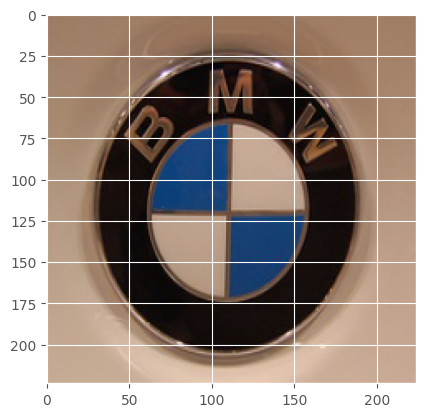

In [ ]:
predimage(imagePaths[60])

1/1 [==============================] - 0s 32ms/step
[array([ 0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0.2,  0. ,
        0. ,  0. , 99.7,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ], dtype=float32)]
McDonalds


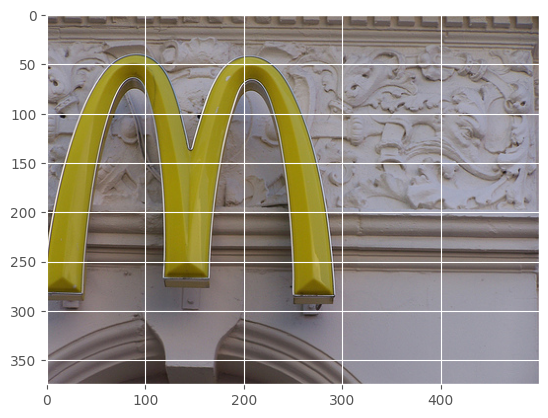

In [ ]:
predimage(testimage[30])

1/1 [==============================] - 0s 55ms/step
[array([ 0. ,  0.1,  0.1,  0. ,  0. , 31.5, 31.7,  0. ,  0. ,  0.2,  0.9,
        1.3,  0.3, 24. ,  0. ,  0. ,  0.1,  0.1,  0.1,  0.3,  0.3,  0.1,
        0.3,  0.1,  2.6,  5.8,  0. ], dtype=float32)]
Fedex


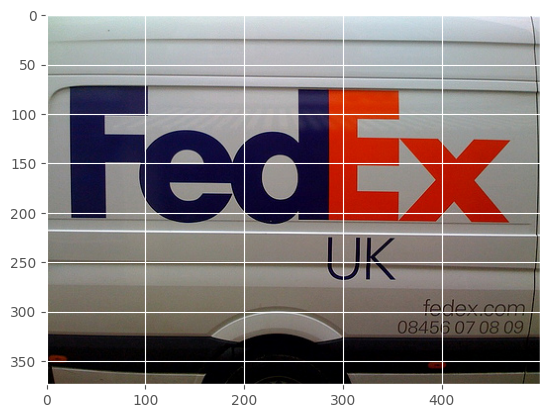

In [ ]:
predimage(testimage[25])

1/1 [==============================] - 0s 43ms/step
[array([ 0. ,  2.6,  0.1,  0. ,  0.2,  0. ,  0. ,  0. ,  0.2,  9.4,  0. ,
        0.2,  0.3,  7.1,  0.1,  5.3,  0. ,  0.5,  0. ,  0. , 12. ,  2.8,
        0. ,  0. , 58.9,  0.4,  0. ], dtype=float32)]
Unicef


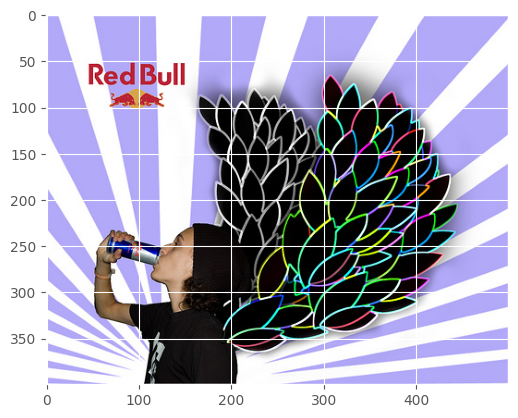

In [ ]:
predimage(testimage[18])

In [ ]:
from google.colab import files
files.download('logo.model')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>